In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
pd.set_option('display.max.colwidth', 130)

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm 
fm._rebuild() 
%matplotlib inline

!apt -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)


import feedparser
from bs4 import BeautifulSoup as bs
import urllib
import urllib.request as req
import requests

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

from konlpy.tag import Kkma, Okt, Komoran
okt = Okt()
from konlpy.utils import pprint

from collections import Counter

import datetime
from datetime import timedelta

In [3]:
import re

from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('wordnet')
import string

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from gensim.models import Word2Vec


# 그래프에서 한글표현을 위해 폰트를 설치합니다.
# %config InlineBackend.figure_format = 'retina'

from plotnine import *
import plotnine

import warnings
warnings.filterwarnings("ignore")


remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
def next_ds(de):
    converted_de = datetime.datetime.strptime(de, '%Y.%m.%d').date()   # de를 datetime 형식으로 변환
    next_day = converted_de + timedelta(days=1)  # 1일 뒤 날짜 구함
    ds = next_day.strftime('%Y.%m.%d')
    return ds

In [5]:
day_list = []
CumNum_list = []

def get_OnlyNewsNum(keyword, p_ds, p_de):
    keyword = '+'.join(keyword.split(' '))

    last = False
    page_num = 1

    cvt_ds = datetime.datetime.strptime(p_ds, '%Y.%m.%d').date()
    cvt_de = datetime.datetime.strptime(p_de, '%Y.%m.%d').date()
    periods = (cvt_de - cvt_ds).days
    ds = p_ds

    for period in range(periods + 1):
        de = ds
        Cum_li = 0 # 페이지별 기사 수 누적 (relation list 포함됨)
        while last == False:
            url = "https://search.naver.com/search.naver?&where=news&query={0}&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=&pd=3&ds={1}&de={2}&docid=&nso=so:r,p:,a:all&mynews=1&cluster_rank=238&start={3}&refresh_start=0".format(keyword,ds,de,str(page_num))
            raw = requests.get(url)
            html = raw.content
            soup = bs(html, 'html.parser')

            page = soup.find('div', {'class':'paging'})
            page_a_list = page.findAll('a')

            ul = soup.find('ul', {'class':'type01'})
            li_list = ul.findAll('li')

            if '다음페이지' in str(page_a_list[-1]):
                Cum_li += len(li_list)  # relation 기사 포함된 li_list 길이 누적시킴
                page_num += 10
                
            else:
                Cum_li += len(li_list)
                CumNum_list.append(Cum_li)
                page_num = 1
                last = True

        day_list.append(ds)
        ds = next_ds(de)
        last=False

In [6]:
get_OnlyNewsNum('춘천', '2020.07.01', '2020.07.14')

In [59]:
cum_dict = {'day' : day_list,
            'CumNum' : CumNum_list}
            
CumNews_df = pd.DataFrame(cum_dict)
CumNews_df

,day,CumNum
0,2020.07.01,1104
1,2020.07.02,632
2,2020.07.03,1234
3,2020.07.04,138
4,2020.07.05,134
5,2020.07.06,599
6,2020.07.07,536
7,2020.07.08,817
8,2020.07.09,753
9,2020.07.10,507


In [9]:
CumNews_df['weekend'] =0

for i in range(len(CumNews_df['day'])):
    day = CumNews_df.iloc[i,0]
    weekOrNot = datetime.datetime.strptime(day, '%Y.%m.%d').date().weekday()
    if  weekOrNot== 5 or weekOrNot == 6 :
        CumNews_df.iloc[i,2] = True
    else: 
        CumNews_df.iloc[i,2] = False
CumNews_df[3:8]

,day,CumNum,weekend
3,2020.07.04,138,True
4,2020.07.05,134,True
5,2020.07.06,599,False
6,2020.07.07,536,False
7,2020.07.08,817,False


In [10]:
CumNews_df['dif'] = CumNews_df.weekend.astype(int).diff()
CumNews_df['group'] = ((CumNews_df.weekend.astype(int).diff() != 0)&(CumNews_df.weekend)).cumsum()
CumNews_df

,day,CumNum,weekend,dif,group
0,2020.07.01,1104,False,NaN,0
1,2020.07.02,632,False,0.0,0
2,2020.07.03,1234,False,0.0,0
3,2020.07.04,138,True,1.0,1
4,2020.07.05,134,True,0.0,1
5,2020.07.06,599,False,-1.0,1
6,2020.07.07,536,False,0.0,1
7,2020.07.08,817,False,0.0,1
8,2020.07.09,753,False,0.0,1
9,2020.07.10,507,False,0.0,1


In [11]:
range_list = CumNews_df[CumNews_df.weekend].groupby('group').day.apply(list)

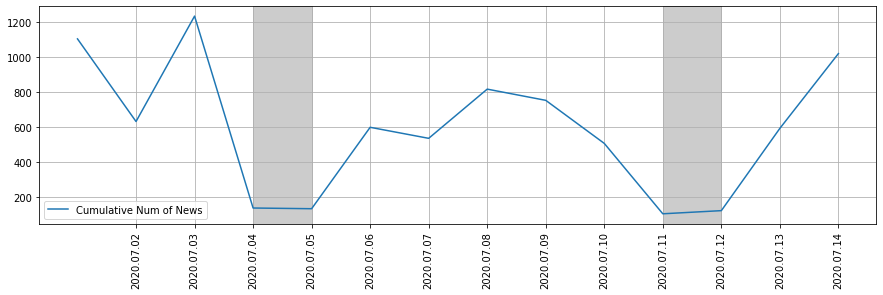

In [13]:
plt.figure(figsize=(15,4))
plt.plot(CumNews_df['day'],CumNews_df['CumNum'], label='Cumulative Num of News')
for (start, end) in range_list:
    plt.axvspan(start, end, color='gray', alpha=0.4)
plt.xticks(np.arange(1,len(CumNews_df['day'])), rotation=90)
plt.grid(True)
plt.legend()
plt.show()

In [18]:
href_list = []
title_list = []
TitDesc_list = []
def Crawling(keyword, date):
    keyword = '+'.join(keyword.split(' '))

    last = False
    page_num = 1

    ds = date
    de = ds
    while last == False:
        url = "https://search.naver.com/search.naver?&where=news&query={0}&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=&pd=3&ds={1}&de={2}&docid=&nso=so:r,p:,a:all&mynews=1&cluster_rank=238&start={3}&refresh_start=0".format(keyword,ds,de,str(page_num))
        raw = requests.get(url)
        html = raw.content
        soup = bs(html, 'html.parser')

        ul = soup.find('ul', {'class':'type01'})
        li_list = ul.findAll('li')

        for li in li_list:
            try:
                #href_list.append(li.dl.dt.a['href'])
                d_list = li.findAll('dd')     #자식 노드 dd가 두 개인데 두 번째 노드에 description이 들어가있으므로 전부 불러온 후 인덱싱할 것임
                title = li.dl.dt.a['title']
                description = d_list[1].text    # 자식 노드 dd의 두 번째에 들어가 있는 description을 text로 불러옴
                title_list.append(title)
                TitDesc_list.append( title + ' ' + description)
            except AttributeError:
                pass

        
        # 마지막 페이지 주소 확인 (다음페이지 버튼이 없으면 종료페이지로 간주)
        page = soup.find('div', {'class':'paging'})
        page_a_list = page.findAll('a')
        if '다음페이지' in str(page_a_list[-1]):
            page_num += 10
        else:
            last = True

In [19]:
Crawling('춘천', '2020.07.03')

In [20]:
TitDesc_okt = []

for item in TitDesc_list:
  item_nouns = ' '.join(okt.nouns(item))
  TitDesc_okt.append(item_nouns)

  tfidf_vectorizer = TfidfVectorizer()
  tfidf_matrix_okt = tfidf_vectorizer.fit_transform(TitDesc_okt)
TitDesc_okt[:3]
#Vectorization

['춘천 의암호 주변 야간 경관 더 춘천 의암호 주변 야간 경관 더 춘천시 시 국비 시비 투입 의암호 야간 경관 개선 사업 추진 고 이번 야간 경관 사업 소양 교 아치 미디어 파사드',
 '춘천 사랑 상품권 판매 달 말 연장 강원 춘천 사랑 상품권 판매 기간 연장 춘천시 춘천 사랑 상품권 판매 당초 춘천 사랑 상품권 판매 코로나 여파',
 '한국 폴리텍 춘천 원주 캠 연속 인력 양성 사업 최우수 한국 폴리텍 강원 대학 춘천 캠퍼스 지역 산업 맞춤 인력 양성 사업 공동 훈련 센터 성과 평가 연속 최우수 등급 춘천 캠퍼스 인프라 구축 훈련 운영 실적 등 개 항목']

In [21]:
df_dict = {'TokenizedTitDesc':TitDesc_okt,
           'TitDesc':TitDesc_list}
doc_df = pd.DataFrame(df_dict)
doc_df['title'] = 0
doc_df['num']=0

for i in range(len(doc_df)):
  doc_df.iloc[i, 3] = i
  doc_df.iloc[i, 2] = title_list[i]
doc_df.head()


topic_df = doc_df

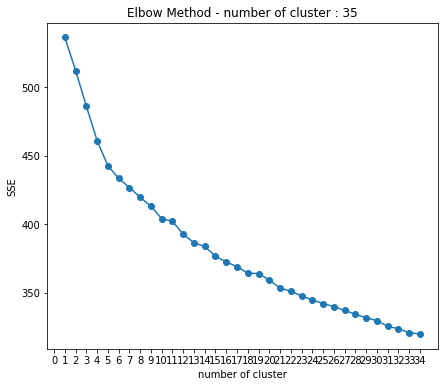

In [22]:
x = normalize(tfidf_matrix_okt)
# L2 정규화

def elbow(normalizedData, Clusters):
    sse = []
    for i in range(1,Clusters):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
        kmeans.fit(normalizedData)
        sse.append(kmeans.inertia_)
    plt.figure(figsize=(7,6))
    plt.plot(range(1,Clusters), sse, marker='o')
    plt.xlabel('number of cluster')
    plt.xticks(np.arange(0,Clusters,1))
    plt.ylabel('SSE')
    plt.title('Elbow Method - number of cluster : '+str(Clusters))
    plt.show()
elbow(x, 35)

In [23]:
tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize)
feature_vect = tfidf_vect.fit_transform(topic_df['TokenizedTitDesc'])

In [44]:
clusters_num = 17

km_cluster = KMeans(n_clusters=clusters_num, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

In [45]:
topic_df['cluster_label'] = cluster_label
topic_df.head()

for i in range(clusters_num):
  print('<<Clustering Label {0}>>'.format(i)+'\n')
  print(topic_df.loc[topic_df['cluster_label']==i])

<<Clustering Label 0>>

                                                                                                                      TokenizedTitDesc  ... cluster_label
66                     날씨 지속 도 경기 강원 등 비 소식 지역별 아침 최저 기온 서울 도 인천 도 춘천 도 강릉 도 대전 도 대구 도 부산 도 전주 도 광주 도 제주 도 낮 최고 기온 서울 도 인천 도 춘천 도 강릉 도  ...             0
74                        중부 내륙 소나기 남부 지방 비 최고 기온 도 기상청 오전 기준 주요 지역 기온 서울 도 인천 도 수원 도 춘천 도 주요 지역 서울 도 인천 도 수원 도 춘천 도 강릉 도 청주 도 대전 도 전주  ...             0
75       밤 서울 경기 소나기 토요일 낮 도 안팎 주요 지역 아침 최저 기온 서울 도 인천 도 수원 도 춘천 도 강릉 도 청주 도 대전 도 전주 도 광주 도 대구 도 부산 도 제주 도 낮 최고 기온 서울 도 인천 도 수원 도 춘천 도  ...             0
93                      남부 지방 비 소식 수도권 오전 미세먼지 날 오전 현재 전국 주요 지역 기온 서울 도 인천 도 수원 도 춘천 도 강릉 도 청주 도 대전 도 전주 도 광주 도 제주 도 대구 도 부산 도 울산 도 창원  ...             0
107                    날씨 지속 도 경기 강원 등 비 소식 지역별 아침 최저 기온 서울 도 인천 도 춘천 도 강릉 도 대전 도 대구 도 부산 도 전주 도 광주 도 제주 도 낮 최고 기온 서울 도 인천 도 춘천 도 강릉 도  ...             0
..                                                  

In [46]:
clustersNum = topic_df['cluster_label'].groupby(topic_df['cluster_label']).count()
df= pd.DataFrame(clustersNum)

In [47]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape : ', cluster_centers.shape)
print(cluster_centers)

cluster_centers shape :  (17, 2614)
[[0.         0.         0.         ... 0.         0.00211071 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [48]:
# 군집별 top n 핵심단어, 그 단어의 중심 위치 상대값, 대상 제목들을 반환함. 
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
    cluster_details = {}
    
    # cluster_centers array 의 값이 큰 순으로 정렬된 index 값을 반환
    # 군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함.  
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    #개별 군집별로 iteration하면서 핵심단어, 그 단어의 중심 위치 상대값, 대상 제목 입력
    for cluster_num in range(clusters_num):
        # 개별 군집별 정보를 담을 데이터 초기화. 
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # cluster_centers_.argsort()[:,::-1] 로 구한 index 를 이용하여 top n 피처 단어를 구함. 
        top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [ feature_names[ind] for ind in top_feature_indexes ]
        
        # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함 
        top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()
        
        # cluster_details 딕셔너리 객체에 개별 군집별 핵심 단어와 중심위치 상대값, 그리고 해당 파일명 입력
        cluster_details[cluster_num]['top_features'] = top_features
        cluster_details[cluster_num]['top_features_value'] = top_feature_values
        filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['title']
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['title'] = filenames
        
    return cluster_details

In [49]:
def print_cluster_details(cluster_details):    
    for cluster_num, cluster_detail in cluster_details.items():
        print('####### Cluster {0}'.format(cluster_num))
        print('Top features:', cluster_detail['top_features'])
        print('Title :',cluster_detail['title'][:7])
        print('==================================================')

In [50]:
feature_names = tfidf_vect.get_feature_names()

cluster_details = get_cluster_details(cluster_model=km_cluster, cluster_data=topic_df,\
                                  feature_names=feature_names, clusters_num=clusters_num, top_n_features=10 )
print_cluster_details(cluster_details)

####### Cluster 0
Top features: ['도', '기온', '강릉', '인천', '서울', '대전', '낮', '최고', '제주', '전주']
Title : ["더운 날씨 지속 '30도까지 올라'.. 경기·강원 등 '비 소식'", '중부 내륙 소나기·남부지방 비…최고 기온 30도까지 올라', '밤부터 서울·경기 소나기…토요일 낮엔 30도 안팎', "남부지방 비 소식…수도권 오전 미세먼지 '나쁨'", "더운 날씨 지속 '30도까지 올라'.. 경기·강원 등 '비 소식'", "더운 날씨 지속 '30도까지 올라'.. 경기·강원 등 '비 소식'", '[오늘의 날씨] 전국 구름 끼고, 내륙 지역 중심 낮기온 30도']
####### Cluster 1
Top features: ['축구단', '천안시', '연기', '체육', '대학교', '기숙사', '경기', '행위', '고속도로', '강원도']
Title : ['천안시축구단, 홈무패의 분위기 이어 춘천원정에서 승리 정조준', "천안시축구단 V 춘천시민 4일 경기 '코로나19' 관련 전격 연기", '한체대도 가혹 행위 의혹..."얼굴에 라면 붓고 성추행"', '해외여행 수요, 강원도 집중예상...경찰순찰차 221대 교통관리 투입', '한체대도 가혹 행위 의혹..."얼굴에 라면 붓고 성추행"', '한체대도 가혹 행위 의혹..."얼굴에 라면 붓고 성추행"', "'학교 기숙사는 지옥이었다'…성추행·폭행 등 '괴롭힘이 일상'"]
####### Cluster 2
Top features: ['속초', '개통', '스위트', '아이파크', '고속', '철도', '인근', '속초역', '용산역', '접근']
Title : ["HDC현산, '속초 아이파크 스위트' 견본주택 이달 말 개관", "HDC현산, '속초 아이파크 스위트' 견본주택 이달 말 개관", "HDC현산, '속초 아이파크 스위트' 견본주택 이달 말 개관", 'HDC현대산업개발 ‘속초 아이파크 스위트’ 7월 견본주택 개관', 'HDC현대산업개발 ‘속초 아이파

In [54]:
# 토큰화 된 문장 리스트를 단어별로 split한 후 2차원 리스트로 저장
WordVoca_list = []
for item in TitDesc_okt:
    WordVoca_list.append(item.split(' '))

# split된 2차원 리스트 중에서 한 글자짜리 단어들을 모두 제외시키고 WordVoca 리스트 생성
# Word2Vec 모델 학습 데이터로 활용됨
WordVoca = []
for i in range(len(WordVoca_list)):
    element = []
    for j in range(len(WordVoca_list[i])):
        if len(WordVoca_list[i][j]) > 1:
            element.append(WordVoca_list[i][j])
    WordVoca.append(element)

In [55]:
def WordSimilarity(word, count):
    model = Word2Vec(sentences=WordVoca, size=100, window=5, min_count=5, workers=4, sg=1)
    model_result = model.most_similar(positive=[word], topn=count)

    Similarity_df = pd.DataFrame(model_result, columns=[word,'Similarity'])
    print('{0}과 유사한 단어 Top {1} :'.format(word, count))
    print(Similarity_df)

In [58]:
WordSimilarity('핸드볼', 10)

핸드볼과 유사한 단어 Top 10 :
   핸드볼  Similarity
0   남자    0.999599
1   국체    0.999247
2   폭행    0.998837
3   소속    0.998562
4   선배    0.998269
5  한체대    0.998178
6   선수    0.998023
7   입건    0.997975
8   수련    0.997819
9   특수    0.997725
